In [161]:
#| default_exp core

# pump design

> API details.

In [162]:
#|hide
from nbdev.showdoc import *

In [163]:
#|export
import numpy as np
import matplotlib.pyplot as plt


class PumpDesign:
    def __init__(self, fluid: str,
                 n_d: float,
                 Q_d: float,
                 H_d: float,
                 head_coefficient: float = 0.5,
                 flow_coefficient_phi: float = 0,
                 epsilon: float=0.045e-3):
        self.fluid = fluid
        self.n_d = n_d
        self.Q_d = Q_d
        self.H_d = H_d
        self.nq = n_d * np.sqrt(Q_d) / H_d ** (3 / 4)
        if flow_coefficient_phi == 0:
            self.flow_coefficient_phi = 3.7838e-3 * self.nq - 0.02919
        self.epsilon = epsilon
        self.head_coefficient_psi = head_coefficient

    def pump_design(self,
                    beta2, blade_thickness,
                    number_of_blades,
                    inlet_impeller_hydraulic_diameter,
                    incidence,
                    volute_height=5e-3,
                    diffusor_area_ratio=2,
                    blade_clearance = 0.05e-3):

        t = blade_thickness
        z = number_of_blades
        dh1 = inlet_impeller_hydraulic_diameter
        i = incidence
        b3 = volute_height
        AR = diffusor_area_ratio
        s = blade_clearance

        g = 9.81
        omega_d = self.n_d / 60 * 2 * np.pi
        d2 = 2 / omega_d * np.sqrt(g * self.H_d / self.head_coefficient_psi)
        u2 = omega_d * d2 / 2
        b2 = self.Q_d / (self.flow_coefficient_phi * u2 * (np.pi * d2 - t * z))
        A2 = np.pi * d2 * b2 - t * z * b2
        c2m = self.Q_d / A2
        w_theta_2 = c2m / np.tan(beta2)

        ns = 51.55 * self.nq
        Kd = 1e-13 * ns ** 3 - 7e-9 * ns ** 2 + 1e-4 * ns + 0.2661
        d1 = Kd * d2
        b1 = (d1 - dh1) / 2
        A1 = np.pi * ((dh1 + d1) / 2) * b1 - t * z * b1
        c1m = self.Q_d / A1
        beta1 = np.arctan(c1m / w_theta_2) + i

        u1 = omega_d * d1 / 2
        alpha1 = np.deg2rad(90)
        c_theta_1 = c1m / np.tan(alpha1)
        w_theta_1 = u1 - c_theta_1
        w1 = np.sqrt(c1m ** 2 + w_theta_1 ** 2)
        sigma = 1 - np.sin(beta2) / (z ** 0.7)
        w_theta_2 = c2m / np.tan(beta2)
        w2 = np.sqrt(c2m ** 2 + w_theta_2 ** 2)
        c_theta_2_slip = sigma * (u2 - w_theta_2)

        diameter_size_check = d1 < d2
        blade_height_size_check = b2 < b1

        Kw = (w1 - w2) / w1
        Ks = (u2 - u1) / c_theta_2_slip

        print("d2 {}".format(d2))
        print(c_theta_2_slip)

        L0 = 1/360 * c_theta_2_slip * d2/2
        L_prev = 0
        A4 = 0
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        theta_list = []
        d_n_list = []
        d_2_list = []
        for theta in range(1, 360, 1):
            coeff_1 = np.pi * L0 * 360**2 /(16 * self.Q_d * theta)
            coeff_2 = -(2 * np.pi * L0 * 360**2 * d2 / (16 * self.Q_d * theta) + 1 / 4)
            coeff_3 = (d2**2 * np.pi * L0 * 360**2 / (16 * self.Q_d * theta) - d2/4)
            d_n_root = np.roots([coeff_1, coeff_2, coeff_3])
            d_n = d_n_root[0]
            c_theta_n = L0 * 360 / (d2/2 + (d_n - d2) / 4)
            d_v = (d_n - d2) / 2
            A4 = np.pi * (d_v/2)**2
            L = theta / 360 * c_theta_n * (d2/2 + (d_v / 2))
            theta_list.append(theta/(360/(2*np.pi)))
            d_n_list.append(max(d_n/2, d2/2 + b3))
            d_2_list.append(d2/2)
            # print("d_v {}  c_theta {}  L {}  Q {}".format(d_v, c_theta_n, L, Q))

        ax.plot(theta_list, d_n_list)
        ax.plot(theta_list, d_2_list)
        ax.set_rmax(0.25)
        # ax.set_rticks([0.25, 0.5, 0.75, 1])  # Less radial ticks
        ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
        ax.grid(True)

        ax.set_title("A line plot on a polar axis", va='bottom')
        plt.show()


        impeller_inner_diameter = d1
        impeller_outer_diameter = d2
        inlet_passage_width = b1
        outlet_passage_width = b2
        volute_height = b3
        blade_clearance = s
        blade_thickness = t
        number_of_impeller_blades = z
        roughness = self.epsilon
        beta1 = beta1
        beta2 = beta2
        alpha1 = alpha1
        volute_throat_area = A4
        A5 = A4 * AR


        return c_theta_2_slip, d2






d2 0.26751668813413493
13.550753330619623


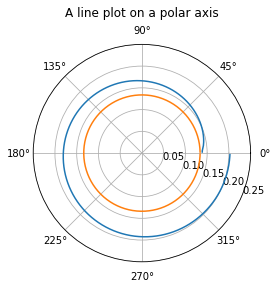

(13.550753330619623, 0.26751668813413493)

In [164]:
pump_design = PumpDesign(fluid="INCOMP::Water", Q_d=0.04, H_d=10, n_d=1000)
pump_design.pump_design(head_coefficient_psi=0.5,
                        beta2=10,
                        blade_thickness=8e-3,
                        number_of_blades=6,
                        inlet_impeller_hydraulic_diameter=0.06,
                        incidence=0)